In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings
import joblib
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
data =pd.read_csv( "/content/drive/MyDrive/Do_An_Tot_Nghiep/healthcare-dataset-stroke-data.csv")

In [ ]:
data[data.isna().any(axis=1)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


In [ ]:
# Xem thông tin tổng quan: kiểu dữ liệu cột, số lượng giá trị không thiếu
if data is not None:
    print("\nThông tin tổng quan về cấu trúc dữ liệu (df.info()):")
    data.info()
else:
    print("DataFrame 'df' chưa được tải.")


Thông tin tổng quan về cấu trúc dữ liệu (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
# Kiểm tra lại df
if data is not None:
    useless_col = 'id'
    if useless_col in data.columns:
        # Thực hiện xóa cột 'id'
        data = data.drop(useless_col, axis=1)
        print(f"Cột '{useless_col}' đã được xóa thành công.")
        print(f"Kích thước mới của DataFrame: {data.shape}")
        # Hiển thị lại 5 dòng đầu sau khi xóa cột để kiểm tra
        print("\nDữ liệu sau khi xóa cột 'id':")
        display(data.head())
    else:
        print(f"Cột '{useless_col}' không tồn tại trong DataFrame.")
else:
    print("DataFrame 'df' chưa được tải.")

Cột 'id' đã được xóa thành công.
Kích thước mới của DataFrame: (5110, 11)

Dữ liệu sau khi xóa cột 'id':


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
# Kiểm tra lại df
if data is not None:
    # Xác định biến mục tiêu
    target = 'stroke'

    # Xác định các cột phân loại: Bao gồm kiểu 'object' và các cột số có ít giá trị duy nhất mang tính phân loại
    categorical_cols = data.select_dtypes(include='object').columns.tolist()
    # Các cột số nhưng thực chất là nhị phân/phân loại
    potential_cat_numeric = ['hypertension', 'heart_disease']
    for col in potential_cat_numeric:
        # Chỉ thêm nếu cột tồn tại, có ít giá trị duy nhất và chưa nằm trong danh sách
        if col in data.columns and data[col].nunique() < 10 and col not in categorical_cols:
             categorical_cols.append(col)

    # Xác định các cột số: Bao gồm các cột kiểu số, loại trừ biến mục tiêu và các cột đã xác định là phân loại
    numerical_cols = data.select_dtypes(include=np.number).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col != target and col not in categorical_cols]

    print(f"Danh sách các cột đặc trưng phân loại (Categorical): \n{categorical_cols}")
    print(f"\nDanh sách các cột đặc trưng số (Numerical): \n{numerical_cols}")
    print(f"\nBiến mục tiêu (Target): {target}")
else:
    print("DataFrame 'data' chưa được tải.")

Danh sách các cột đặc trưng phân loại (Categorical): 
['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease']

Danh sách các cột đặc trưng số (Numerical): 
['age', 'avg_glucose_level', 'bmi']

Biến mục tiêu (Target): stroke



📊 Phân tích cột: gender


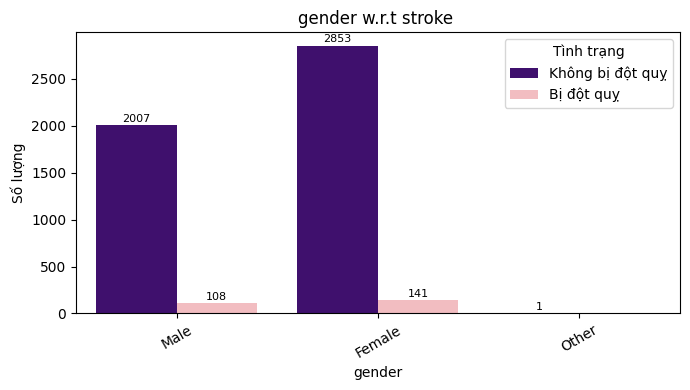

📈 Tỷ lệ bị đột quỵ theo nhóm (gender):
gender
Male      5.11%
Female    4.71%
Other     0.00%
Name: stroke, dtype: object
--------------------------------------------------

📊 Phân tích cột: ever_married


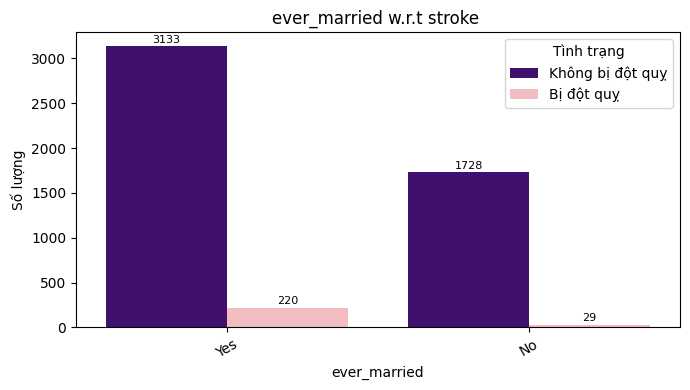

📈 Tỷ lệ bị đột quỵ theo nhóm (ever_married):
ever_married
Yes    6.56%
No     1.65%
Name: stroke, dtype: object
--------------------------------------------------

📊 Phân tích cột: work_type


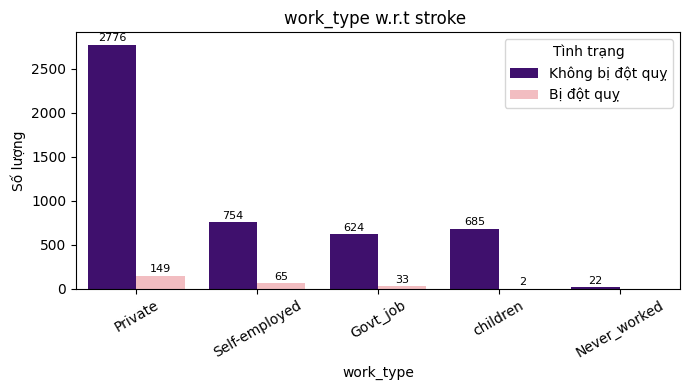

📈 Tỷ lệ bị đột quỵ theo nhóm (work_type):
work_type
Self-employed    7.94%
Private          5.09%
Govt_job         5.02%
children         0.29%
Never_worked     0.00%
Name: stroke, dtype: object
--------------------------------------------------

📊 Phân tích cột: Residence_type


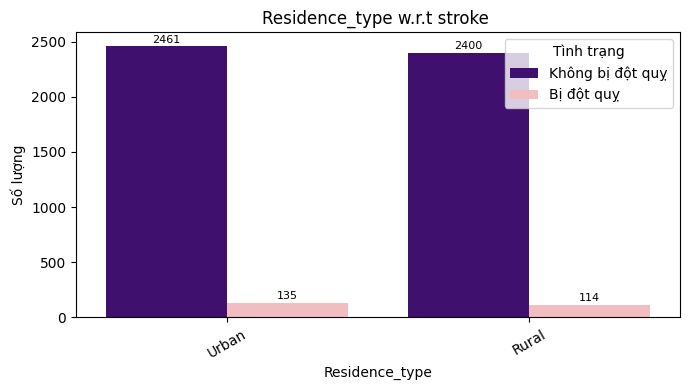

📈 Tỷ lệ bị đột quỵ theo nhóm (Residence_type):
Residence_type
Urban    5.20%
Rural    4.53%
Name: stroke, dtype: object
--------------------------------------------------

📊 Phân tích cột: smoking_status


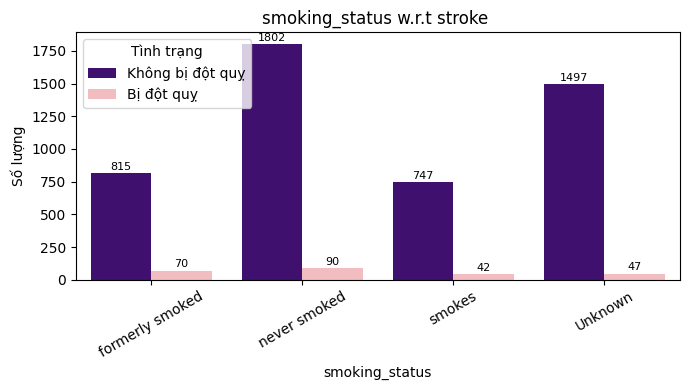

📈 Tỷ lệ bị đột quỵ theo nhóm (smoking_status):
smoking_status
formerly smoked    7.91%
smokes             5.32%
never smoked       4.76%
Unknown            3.04%
Name: stroke, dtype: object
--------------------------------------------------

📊 Phân tích cột: hypertension


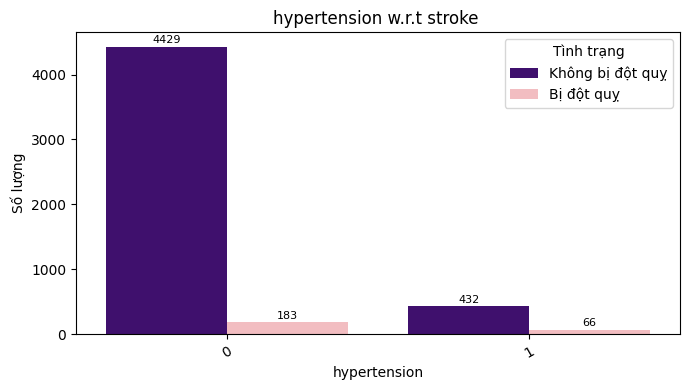

📈 Tỷ lệ bị đột quỵ theo nhóm (hypertension):
hypertension
1    13.25%
0     3.97%
Name: stroke, dtype: object
--------------------------------------------------

📊 Phân tích cột: heart_disease


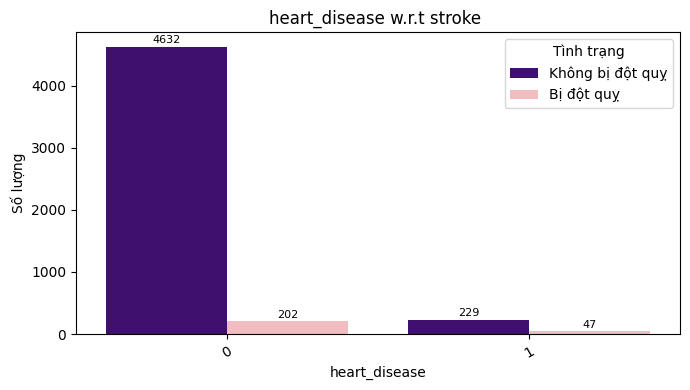

📈 Tỷ lệ bị đột quỵ theo nhóm (heart_disease):
heart_disease
1    17.03%
0     4.18%
Name: stroke, dtype: object
--------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Danh sách các cột phân loại bạn muốn phân tích
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status','hypertension', 'heart_disease']

# Duyệt qua từng cột
for col in categorical_cols:
    print(f"\n📊 Phân tích cột: {col}")

    # 1. Biểu đồ cột chồng (số lượng)
    plt.figure(figsize=(7, 4))
    ax = sns.countplot(x=col, hue="stroke", data=data, palette=["#3f007d", "#fbb4b9"])

    # Ghi giá trị số lên mỗi cột
    for container in ax.containers:
        ax.bar_label(container, fmt="%.0f", label_type="edge", padding=1, fontsize=8)

    plt.title(f'{col} w.r.t stroke ', fontsize=12)
    plt.xlabel(col)
    plt.ylabel("Số lượng")
    plt.legend(["Không bị đột quỵ", "Bị đột quỵ"], title="Tình trạng")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    # 2. Tính tỷ lệ bị đột quỵ theo nhóm
    stroke_rate = data.groupby(col)['stroke'].mean().sort_values(ascending=False)

    print(f"📈 Tỷ lệ bị đột quỵ theo nhóm ({col}):")
    print(stroke_rate.map("{:.2%}".format))  # In dưới dạng %

    print("-" * 50)



--- Phân tích chi tiết các Đặc trưng Phân loại ---

--- Cột: gender ---
Số lượng giá trị duy nhất: 3
Tần suất các giá trị:
gender
Female    58.59%
Male      41.39%
Other      0.02%
Name: proportion, dtype: object


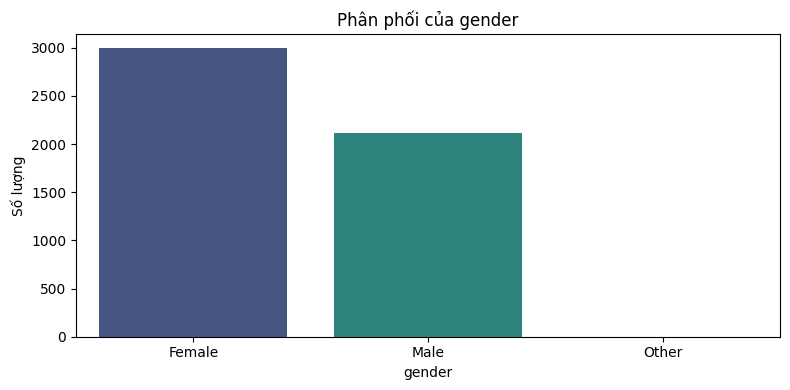

-------------------------------

--- Cột: ever_married ---
Số lượng giá trị duy nhất: 2
Tần suất các giá trị:
ever_married
Yes    65.62%
No     34.38%
Name: proportion, dtype: object


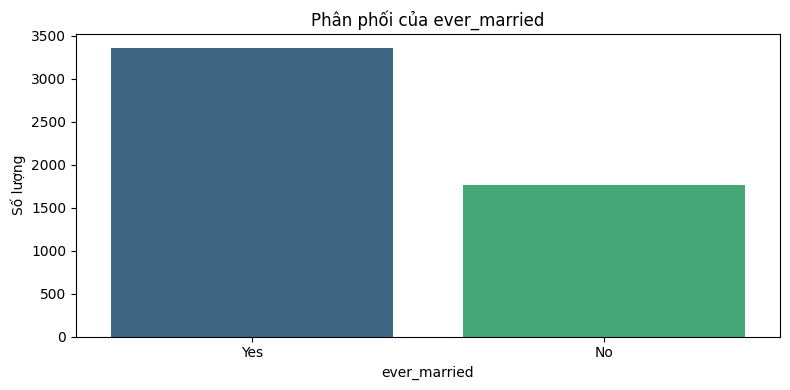

-------------------------------------

--- Cột: work_type ---
Số lượng giá trị duy nhất: 5
Tần suất các giá trị:
work_type
Private          57.24%
Self-employed    16.03%
children         13.44%
Govt_job         12.86%
Never_worked      0.43%
Name: proportion, dtype: object


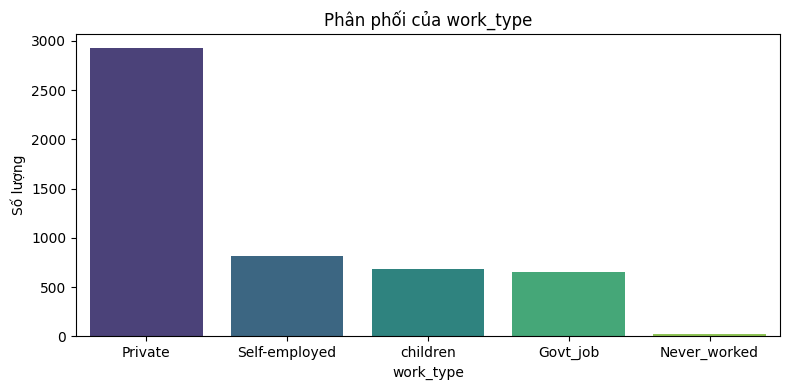

----------------------------------

--- Cột: Residence_type ---
Số lượng giá trị duy nhất: 2
Tần suất các giá trị:
Residence_type
Urban    50.80%
Rural    49.20%
Name: proportion, dtype: object


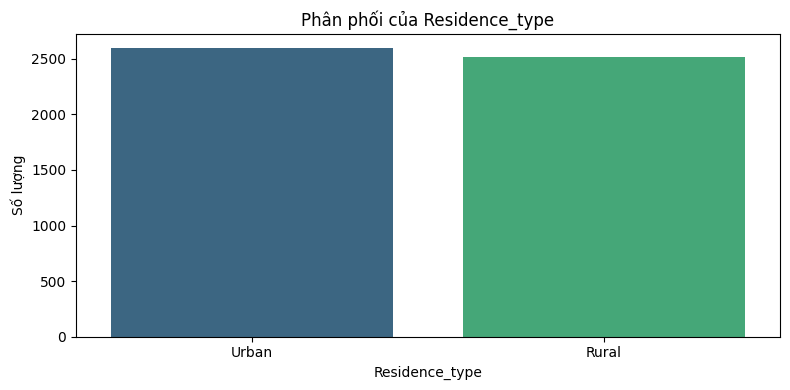

---------------------------------------

--- Cột: smoking_status ---
Số lượng giá trị duy nhất: 4
Tần suất các giá trị:
smoking_status
never smoked       37.03%
Unknown            30.22%
formerly smoked    17.32%
smokes             15.44%
Name: proportion, dtype: object


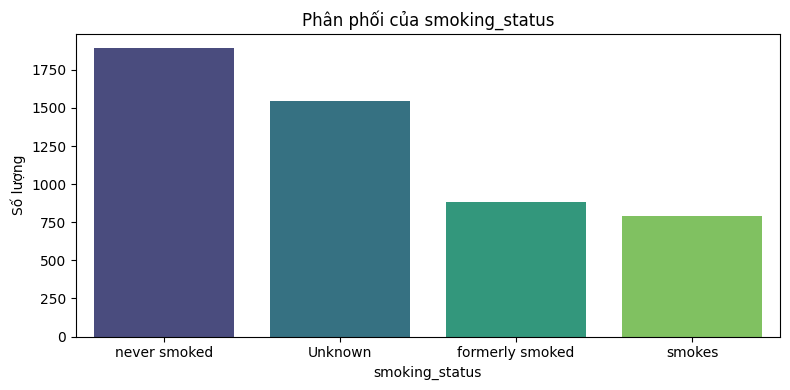

---------------------------------------

--- Cột: hypertension ---
Số lượng giá trị duy nhất: 2
Tần suất các giá trị:
hypertension
0    90.25%
1     9.75%
Name: proportion, dtype: object


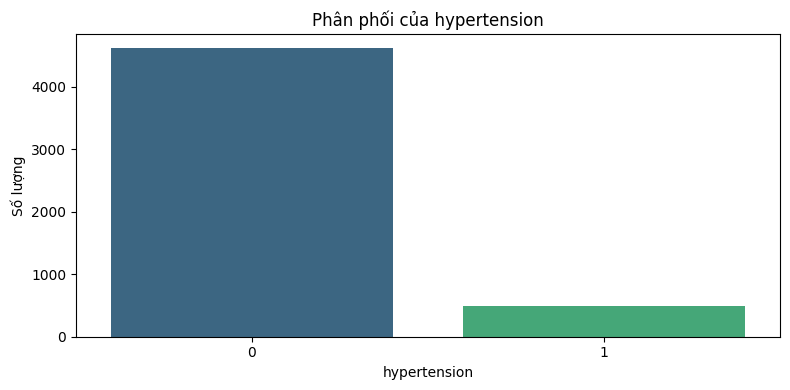

-------------------------------------

--- Cột: heart_disease ---
Số lượng giá trị duy nhất: 2
Tần suất các giá trị:
heart_disease
0    94.60%
1     5.40%
Name: proportion, dtype: object


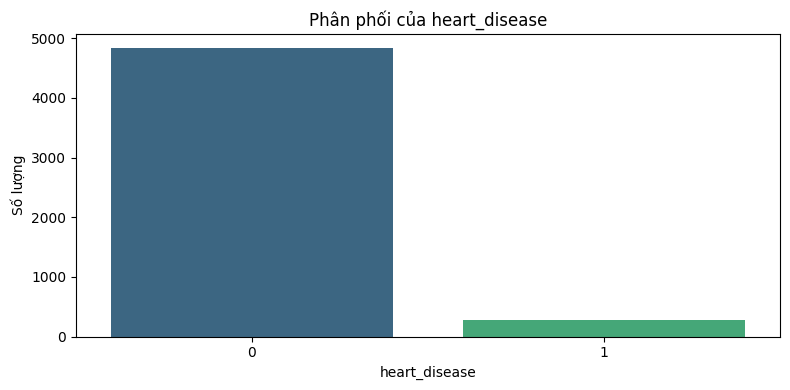

--------------------------------------

Lưu ý: Cột 'gender' có 1 giá trị 'Other'. Trong khuôn khổ bài này, giá trị này sẽ được xử lý như một hạng mục riêng biệt khi mã hóa.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

if data is not None and 'categorical_cols' in locals() and categorical_cols:
    print("\n--- Phân tích chi tiết các Đặc trưng Phân loại ---")
    for col in categorical_cols:
        print(f"\n--- Cột: {col} ---")
        print(f"Số lượng giá trị duy nhất: {data[col].nunique()}")
        print("Tần suất các giá trị:")
        print(data[col].value_counts(normalize=True).map('{:.2%}'.format))  # Hiển thị tỷ lệ %

        # Vẽ biểu đồ countplot dạng cột đứng
        plt.figure(figsize=(8, 4))  # Kích thước phù hợp cho từng biểu đồ
        sns.countplot(x=col, data=data, order=data[col].value_counts().index, palette='viridis')  # Đổi từ y=col sang x=col
        plt.title(f'Phân phối của {col}', fontsize=12)
        plt.xlabel(col, fontsize=10)
        plt.ylabel('Số lượng', fontsize=10)
        plt.tight_layout()
        plt.show()
        print("-" * (len(col) + 25))

    # Ghi chú về giá trị 'Other' nếu có
    if 'gender' in data.columns and 'Other' in data['gender'].unique():
        other_count = data[data['gender'] == 'Other'].shape[0]
        print(f"\nLưu ý: Cột 'gender' có {other_count} giá trị 'Other'. Trong khuôn khổ bài này, giá trị này sẽ được xử lý như một hạng mục riêng biệt khi mã hóa.")
else:
    print("DataFrame 'df' chưa được tải hoặc chưa xác định được `categorical_cols`.")



>>> Khám phá phân phối dữ liệu dạng số (có phân biệt tình trạng đột quỵ) <<<

Phân phối của cột: age


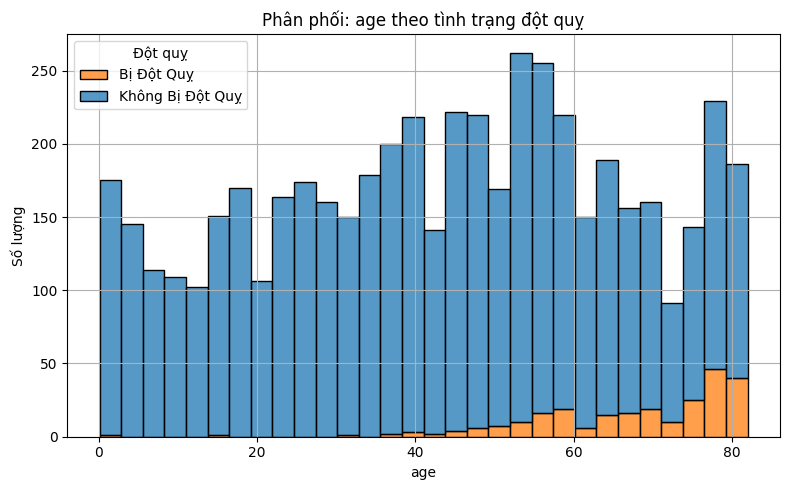


Phân phối của cột: avg_glucose_level


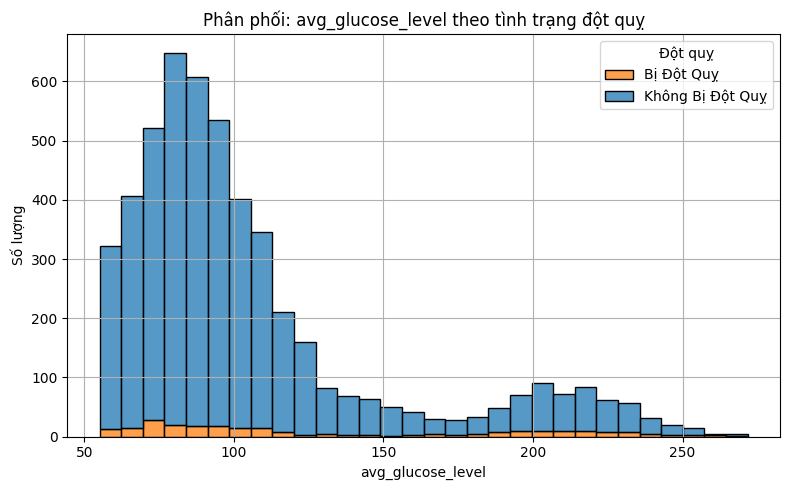


Phân phối của cột: bmi


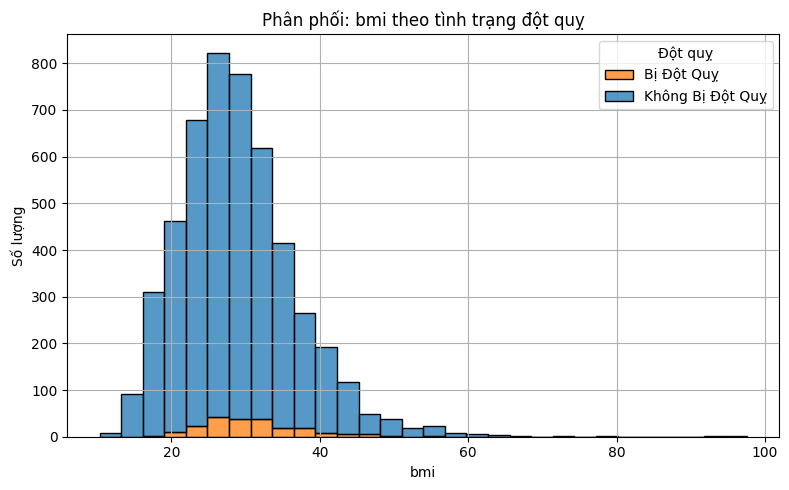

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kiểm tra DataFrame và danh sách cột số
if data is not None and 'numerical_cols' in locals() and numerical_cols:
    print("\n>>> Khám phá phân phối dữ liệu dạng số (có phân biệt tình trạng đột quỵ) <<<")

    for column in numerical_cols[:3]:  # Chỉ lấy 3 cột đầu tiên
        print(f"\nPhân phối của cột: {column}")
        plt.figure(figsize=(8, 5))
        sns.histplot(data=data, x=column, hue="stroke", bins=30, multiple="stack")
        plt.title(f'Phân phối: {column} theo tình trạng đột quỵ', fontsize=12)
        plt.xlabel(column, fontsize=10)
        plt.ylabel('Số lượng', fontsize=10)
        plt.legend(title="Đột quỵ", labels=["Bị Đột Quỵ", "Không Bị Đột Quỵ"])  # đảm bảo chú thích đúng
        plt.tight_layout()
        plt.grid(True)
        plt.show()
else:
    print("Chưa có dữ liệu hoặc danh sách cột số (`numerical_cols`) chưa được xác định.")



>>> Tổng quan biến mục tiêu: 'stroke' <<<

Số lượng mỗi lớp:
stroke
0    4861
1     249
Name: count, dtype: int64

Tỷ lệ phần trăm:
stroke
0    95.13%
1     4.87%
Name: proportion, dtype: object


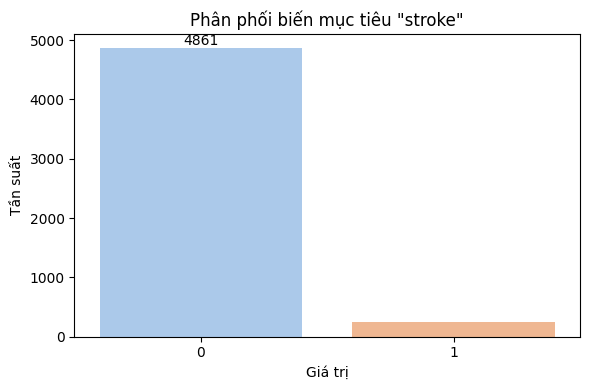


⚠️ Lớp thiểu số chỉ chiếm 4.87%. Dữ liệu mất cân bằng nghiêm trọng.


In [ ]:
if data is not None and target in data.columns:
    print(f"\n>>> Tổng quan biến mục tiêu: '{target}' <<<")

    value_counts = data[target].value_counts()
    value_percent = data[target].value_counts(normalize=True) * 100

    print("\nSố lượng mỗi lớp:")
    print(value_counts)
    print("\nTỷ lệ phần trăm:")
    print(value_percent.apply(lambda x: f"{x:.2f}%"))

    # Vẽ biểu đồ
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x=target, data=data, palette='pastel')
    plt.title(f'Phân phối biến mục tiêu "{target}"', fontsize=12)
    plt.xlabel('Giá trị', fontsize=10)
    plt.ylabel('Tần suất', fontsize=10)
    ax.bar_label(ax.containers[0])
    plt.tight_layout()
    plt.show()

    # Kiểm tra mất cân bằng
    minority_pct = value_percent.min()
    if minority_pct < 15:
        print(f"\n⚠️ Lớp thiểu số chỉ chiếm {minority_pct:.2f}%. Dữ liệu mất cân bằng nghiêm trọng.")
    else:
        print("\n✅ Dữ liệu tương đối cân bằng.")
else:
    print("Không thể phân tích: 'data' chưa có dữ liệu hoặc thiếu cột mục tiêu.")


In [ ]:
if data is not None:
    print(">>> Phân tích dữ liệu khuyết <<<")
    na_counts = data.isnull().sum()
    cols_with_na = na_counts[na_counts > 0]

    if cols_with_na.any():
        print("Phát hiện các cột có dữ liệu trống:")
        print(cols_with_na)
        total_na = cols_with_na.sum()
        print(f"\nTổng số ô trống toàn bộ bảng: {total_na}")
    else:
        print("Dữ liệu đầy đủ, không có giá trị nào bị thiếu.")
        total_na = 0
else:
    print("Không thể kiểm tra — dữ liệu chưa được nạp.")
    total_na = -1  # Biến dùng để đánh dấu lỗi hoặc trạng thái chưa sẵn sàng


>>> Phân tích dữ liệu khuyết <<<
Phát hiện các cột có dữ liệu trống:
bmi    201
dtype: int64

Tổng số ô trống toàn bộ bảng: 201


In [ ]:
# 1. Xử lý giá trị thiếu
if data['bmi'].isnull().any():
    bmi_mean = data['bmi'].mean()
    data['bmi'].fillna(bmi_mean, inplace=True)
    print(f"Đã thay thế giá trị thiếu trong 'bmi' bằng trung bình: {bmi_mean:.2f}")
else:
    print("Không có giá trị thiếu trong cột 'bmi'.")

Đã thay thế giá trị thiếu trong 'bmi' bằng trung bình: 28.89


In [ ]:
# 2. Mã hóa các cột phân loại
label_encoders = {}
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# 3. Tách đặc trưng và nhãn
X = data.drop(columns=['stroke'])
y = data['stroke']

# 4. Chia dữ liệu thành train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Xem trước 5 dòng đầu sau khi mã hóa
print(data[categorical_columns].head())


   gender  ever_married  work_type  Residence_type  smoking_status
0       1             1          2               1               1
1       0             1          3               0               2
2       1             1          2               0               2
3       0             1          2               1               3
4       0             1          3               0               2


Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


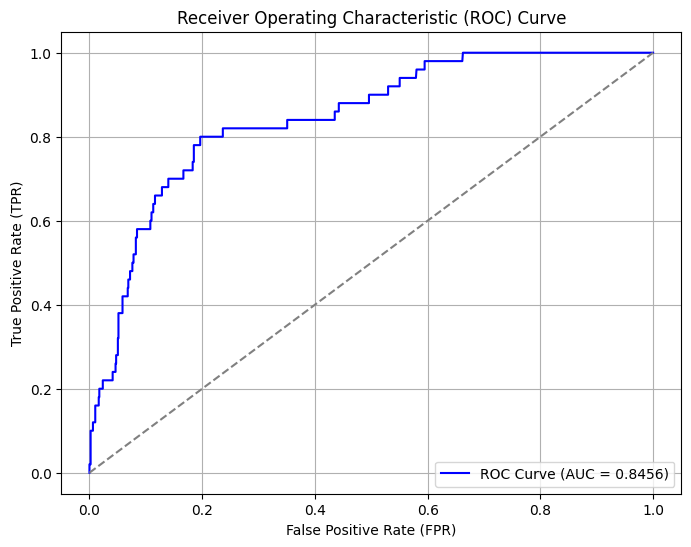

AUC: 0.8456

Best Threshold: 0.70
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.6}
Final Accuracy: 0.8875
Final AUC: 0.8456
Final F1: 0.3353
Final Precision: 0.2358
Final Recall: 0.5800


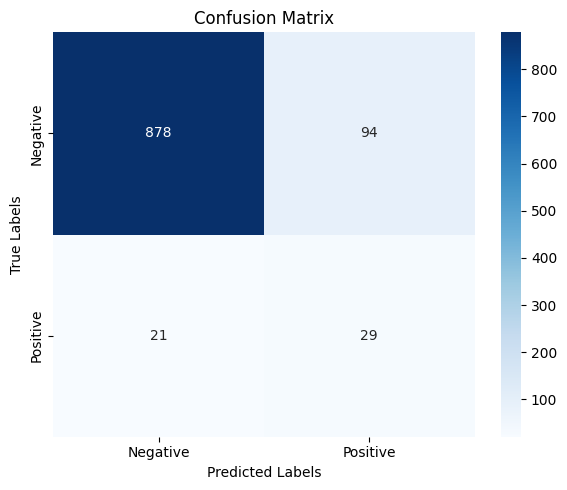

Train AUC: 0.8774755753568562

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       972
           1       0.24      0.58      0.34        50

    accuracy                           0.89      1022
   macro avg       0.61      0.74      0.64      1022
weighted avg       0.94      0.89      0.91      1022



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
# --- Tính scale_pos_weight ---
y_train_series = pd.Series(y_train)
scale_pos_weight = y_train_series.value_counts()[0] / y_train_series.value_counts()[1]

# --- Khởi tạo mô hình ---
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)

# --- Không gian tham số cần thử nghiệm ---
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 9, 12],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# --- Tìm tham số tốt nhất bằng GridSearchCV ---
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# --- Huấn luyện ---
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# --- Dự đoán ---
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# --- Tối ưu ngưỡng dựa trên F1 ---
thresholds = np.arange(0.0, 1.0, 0.05)
best_threshold = 0.6
best_f1 = 0

for threshold in thresholds:
    y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_adjusted)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# --- Đánh giá cuối ---
y_pred_final = (y_pred_proba >= best_threshold).astype(int)
final_f1 = f1_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_accuracy = accuracy_score(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, y_pred_proba)

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {final_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- In kết quả ---
print(f"AUC: {final_auc:.4f}")
print(f"\nBest Threshold: {best_threshold:.2f}")
print(f"Best Params: {grid_search.best_params_}")
print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Final AUC: {final_auc:.4f}")
print(f"Final F1: {final_f1:.4f}")
print(f"Final Precision: {final_precision:.4f}")
print(f"Final Recall: {final_recall:.4f}")
# --- Vẽ ma trận nhầm lẫn ---
cm = confusion_matrix(y_test, y_pred_final)
labels = ['Negative', 'Positive']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()

plt.show()
train_pred = best_model.predict_proba(X_train)[:, 1]
print("Train AUC:", roc_auc_score(y_train, train_pred))

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_final, digits=2))